In [1]:
[] !rm -rf /opt/conda/lib/python3.10/site-packages/fsspec*

In [2]:
!pip install fsspec==2024.6.1 --force-reinstall --no-deps

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)


In [ ]:
#Install all dependencies

Number of bands: 12


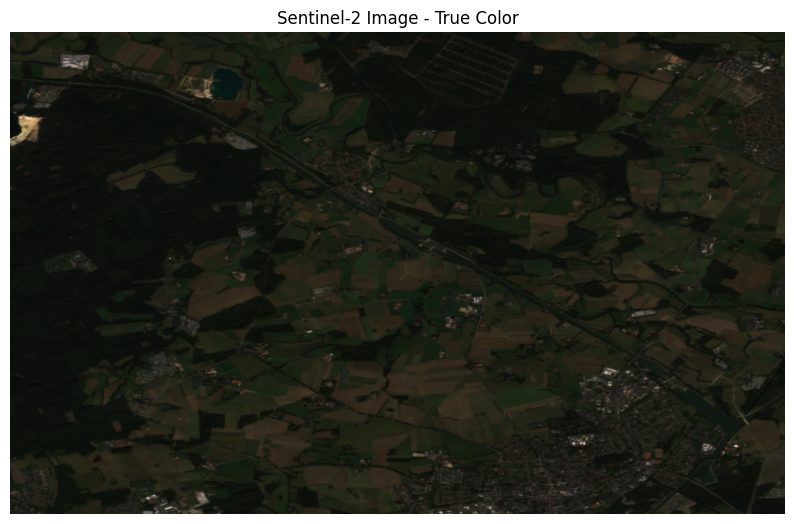

In [40]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

def visualize_sentinel2_tiff(image_path):
    # Open the TIFF image
    with rasterio.open(image_path) as src:
        # Read the image data
        image = src.read()

        # Check the number of bands
        print(f"Number of bands: {src.count}")
        
        # If there are more than 3 bands, choose the typical RGB bands (e.g., B4, B3, B2 for Sentinel-2)
        if src.count >= 3:
            # B4 (Red), B3 (Green), B2 (Blue) -> commonly used for true color
            red_band = image[3]  # B4
            green_band = image[2]  # B3
            blue_band = image[1]  # B2

            # Stack the bands into an RGB image
            rgb = np.stack([red_band, green_band, blue_band], axis=2)

            # Normalize the image data to 0-1 range for visualization
            rgb_normalized = rgb / np.max(rgb)

            # Plot the image
            plt.figure(figsize=(10, 10))
            plt.imshow(rgb_normalized)
            plt.title('Sentinel-2 Image - True Color')
            plt.axis('off')
            plt.show()

        else:
            # If the image has less than 3 bands, show all available bands
            show(image, cmap='gray', title="Sentinel-2 Image")

# Example usage
image_path = 's3://solafune/train_images/images/train_24.tif'
visualize_sentinel2_tiff(image_path)


In [28]:
import rasterio
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import s3fs

def load_image(image_s3_uri):
    """Load an image from S3 using rasterio."""
    fs = s3fs.S3FileSystem()
    with fs.open(image_s3_uri, 'rb') as f:
        src = rasterio.open(f)
    return src

def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None




In [19]:
def convert_to_geojson(data):
    """
    Converts a list of dictionaries in the specified format to GeoJSON.
    
    Args:
        data: A list of dictionaries containing 'class' and 'segmentation' keys.
    
    Returns:
        A GeoJSON feature collection.
    """
    features = []
    for item in data:
        polygon = []
        for i in range(0, len(item['segmentation']), 2):
            polygon.append([item['segmentation'][i], item['segmentation'][i+1]])
        features.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [polygon]
            },
            "properties": {"class": item['class']}
        })
    return {"type": "FeatureCollection", "features": features}



In [20]:
def visualize_image_with_annotations(image_s3_uri, annotation_s3_uri):
    """Visualize an image with its annotations from S3."""
    # Load image
    src = load_image(image_s3_uri)
    
    # Extract the filename from the S3 URI
    image_filename = image_s3_uri.split('/')[-1]
    
    # Load annotations
    annotations = load_annotations(annotation_s3_uri, image_filename)
    
    if not annotations:
        print(f"No annotations found for {image_filename}")
        return
    
    # Convert annotations to GeoJSON
    geojson_data = convert_to_geojson(annotations)
    
    # Convert GeoJSON to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson_data)
    
    # Plot the raster image and the annotations
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot raster
    ax.imshow(src.read(2), cmap="gray")
    ax.set_title(f"Image and Annotations for {image_filename}")
    
    # Plot field segmentation
    gdf.boundary.plot(ax=ax, edgecolor="red")
    
    plt.show()



In [21]:
# Load Json
train_annotation_s3_uri = 's3://solafune/train_annotation.json'


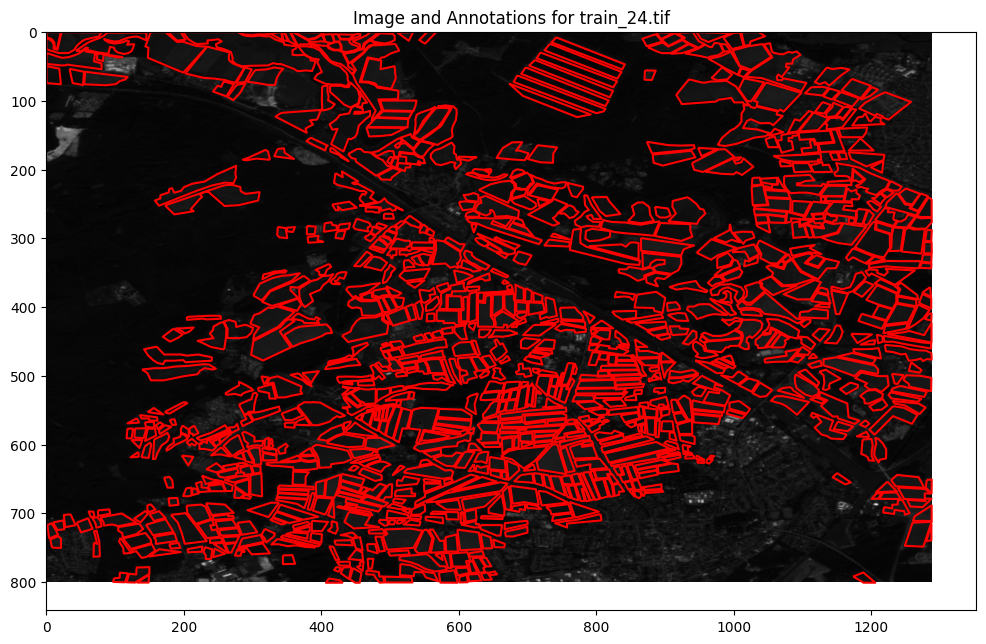

In [41]:
#Sample Image
train_image_s3_uri = 's3://solafune/train_images/images/train_24.tif'
visualize_image_with_annotations(train_image_s3_uri, train_annotation_s3_uri)

In [30]:
def visualize_only_polygons(annotation_s3_uri, image_filename):
    """Visualize only the polygons from the annotations."""
    
    # Load annotations
    annotations = load_annotations(annotation_s3_uri, image_filename)
    
    if not annotations:
        print(f"No annotations found for {image_filename}")
        return
    
    # Convert annotations to GeoJSON
    geojson_data = convert_to_geojson(annotations)
    
    # Convert GeoJSON to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson_data)
    
    # Plot the polygons only
    fig, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(ax=ax, edgecolor="red", facecolor="blue", alpha=0.5)  # Set alpha for transparency and solid fill
    ax.set_title(f"Polygons for {image_filename}")
    
    plt.show()

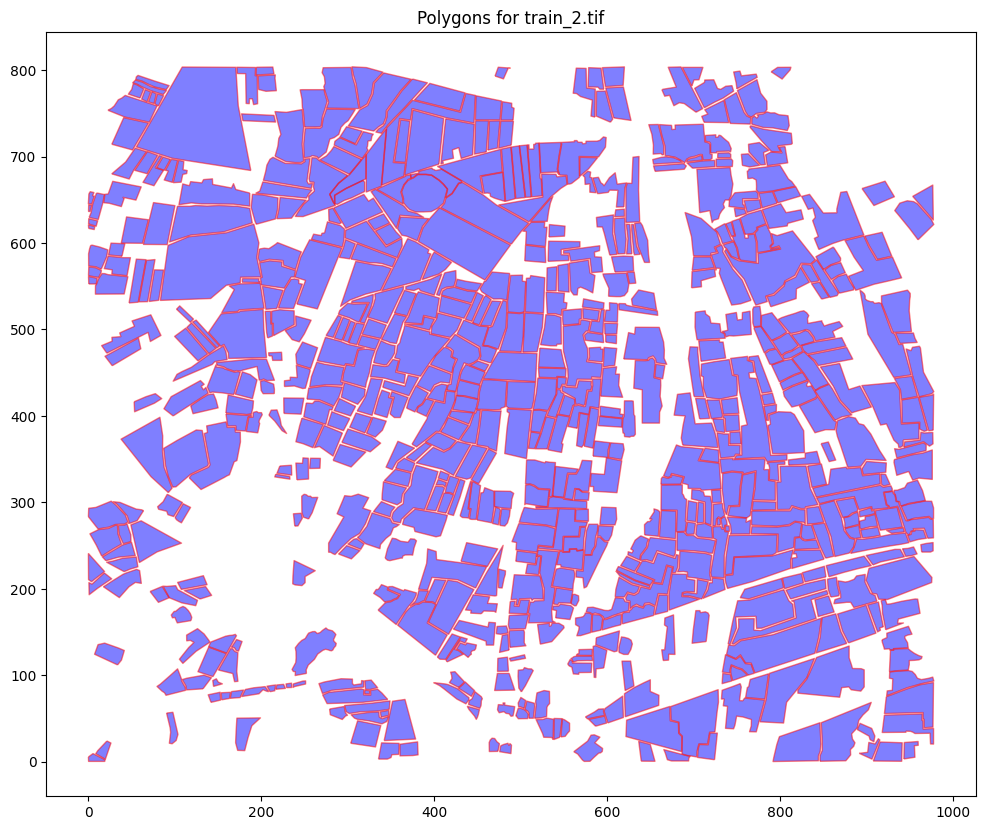

In [31]:
visualize_only_polygons(train_annotation_s3_uri, 'train_2.tif')

In [32]:
import rasterio
import matplotlib.pyplot as plt
import json
import geopandas as gpd
import s3fs

def load_image(image_s3_uri):
    """Load an image from S3 using rasterio."""
    fs = s3fs.S3FileSystem()
    with fs.open(image_s3_uri, 'rb') as f:
        src = rasterio.open(f)
    return src

def load_annotations(annotation_s3_uri, image_filename):
    """Load annotations for a specific image from a JSON file on S3."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    for img in data['images']:
        if img['file_name'] == image_filename:
            return img['annotations']
    return None

def convert_to_geojson(data):
    """
    Converts a list of dictionaries in the specified format to GeoJSON.
    
    Args:
        data: A list of dictionaries containing 'class' and 'segmentation' keys.
    
    Returns:
        A GeoJSON feature collection.
    """
    features = []
    for item in data:
        polygon = []
        for i in range(0, len(item['segmentation']), 2):
            polygon.append([item['segmentation'][i], item['segmentation'][i+1]])
        features.append({
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [polygon]
            },
            "properties": {"class": item['class']}
        })
    return {"type": "FeatureCollection", "features": features}

def extract_bounding_boxes(geojson_data):
    """
    Extract bounding boxes from GeoJSON data.
    
    Args:
        geojson_data: A GeoJSON feature collection.
    
    Returns:
        A list of bounding boxes in the format [x_min, y_min, x_max, y_max].
    """
    gdf = gpd.GeoDataFrame.from_features(geojson_data)
    bounding_boxes = []
    
    for _, row in gdf.iterrows():
        minx, miny, maxx, maxy = row.geometry.bounds
        bounding_boxes.append([minx, miny, maxx, maxy])
    
    return bounding_boxes

def visualize_image_with_bounding_boxes(image_s3_uri, annotation_s3_uri):
    """Visualize an image with its bounding boxes from S3."""
    # Load image
    src = load_image(image_s3_uri)
    
    # Extract the filename from the S3 URI
    image_filename = image_s3_uri.split('/')[-1]
    
    # Load annotations
    annotations = load_annotations(annotation_s3_uri, image_filename)
    
    if not annotations:
        print(f"No annotations found for {image_filename}")
        return
    
    # Convert annotations to GeoJSON
    geojson_data = convert_to_geojson(annotations)
    
    # Extract bounding boxes
    bounding_boxes = extract_bounding_boxes(geojson_data)
    
    # Plot the raster image and the bounding boxes
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot raster
    ax.imshow(src.read(2), cmap="gray")
    ax.set_title(f"Bounding Boxes for {image_filename}")
    
    # Plot bounding boxes
    for bbox in bounding_boxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    
    plt.show()




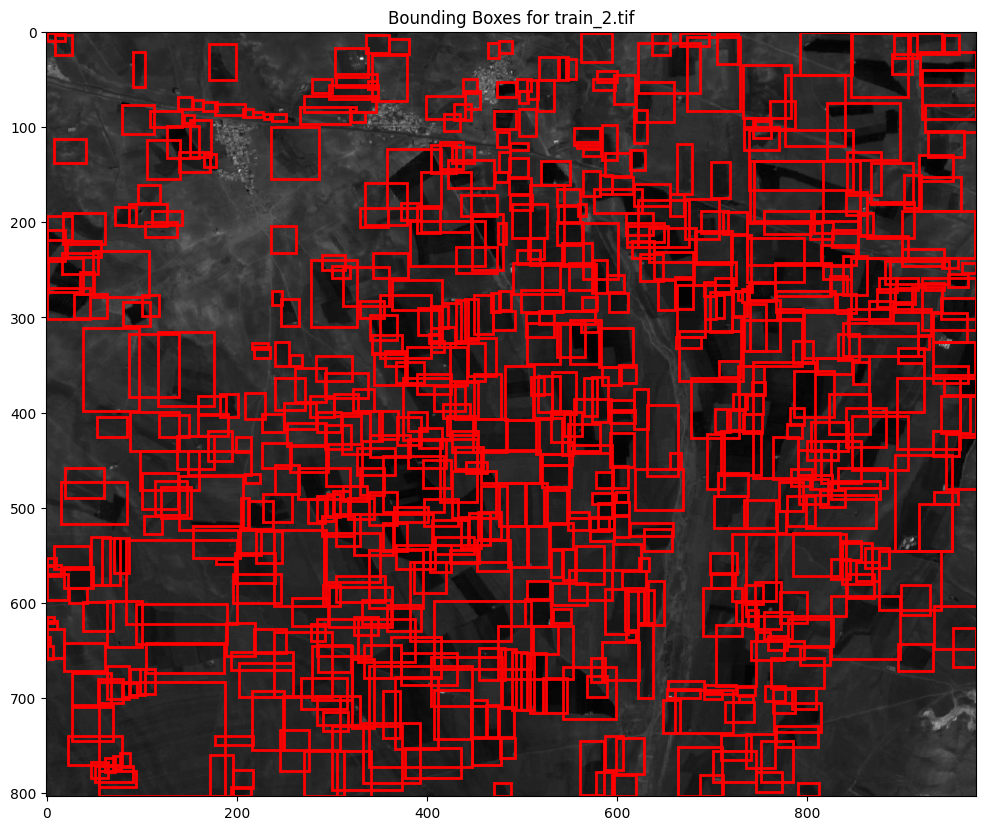

In [33]:
# Sample usage
train_image_s3_uri = 's3://solafune/train_images/images/train_2.tif'
train_annotation_s3_uri = 's3://solafune/train_annotation.json'
visualize_image_with_bounding_boxes(train_image_s3_uri, train_annotation_s3_uri)

In [103]:
import geopandas as gpd
import json
import s3fs
from shapely.geometry import Polygon

def extract_bounding_boxes(annotation_s3_uri):
    """Extract bounding boxes from polygons."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    annotations = {}
    
    for img in data['images']:
        image_filename = img['file_name']
        bboxes = []
        for ann in img['annotations']:
            segmentation = ann['segmentation']
            polygon = Polygon([(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)])
            bbox = polygon.bounds  # returns (minx, miny, maxx, maxy)
            bboxes.append(bbox)
        annotations[image_filename] = bboxes
    
    return annotations



In [104]:

# Example usage
train_annotation_s3_uri = 's3://solafune/train_annotation.json'
bounding_boxes = extract_bounding_boxes(train_annotation_s3_uri)

In [105]:
import json
import s3fs
import numpy as np
from shapely.geometry import Polygon

def polygon_to_bbox(polygon):
    """Convert a polygon to a bounding box [xmin, ymin, xmax, ymax]."""
    poly = Polygon(polygon)
    minx, miny, maxx, maxy = poly.bounds
    return [minx, miny, maxx, maxy]

def load_annotations_and_convert_to_bboxes(annotation_s3_uri):
    """Load annotations from S3 and convert polygons to bounding boxes."""
    fs = s3fs.S3FileSystem()
    with fs.open(annotation_s3_uri, 'r') as f:
        data = json.load(f)
    
    annotations = []
    for img in data['images']:
        filename = img['file_name']
        boxes = []
        for ann in img['annotations']:
            # Print the segmentation to debug
            #print(f"Debug: Segmentation data for {filename} -> {ann['segmentation']}")
            
            segmentation = ann['segmentation']
            
            # Check if segmentation is already a polygon
            if isinstance(segmentation[0], list):
                # If segmentation is a list of lists, take the first polygon
                polygon = segmentation[0]
            else:
                # If segmentation is a flat list, convert it into pairs
                polygon = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]
            
            bbox = polygon_to_bbox(polygon)
            boxes.append(bbox)
        
        annotations.append({'image_filename': filename, 'boxes': boxes})
    
    return annotations

# Example usage
train_annotation_s3_uri = 's3://solafune/train_annotation.json'
annotations = load_annotations_and_convert_to_bboxes(train_annotation_s3_uri)



In [108]:
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import s3fs

class RCNN_Dataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.fs = s3fs.S3FileSystem()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Get image filename and bounding boxes
        image_filename = self.annotations[idx]['image_filename']
        boxes = self.annotations[idx]['boxes']
        
        image_path = os.path.join(self.image_dir, image_filename)
        
        with self.fs.open(image_path, 'rb') as f:
            with rasterio.open(f) as src:
                image = src.read([4, 3, 2])  # Select RGB bands, typically bands 4, 3, 2 for Sentinel-2
                image = np.moveaxis(image, 0, -1)  # Convert to [H, W, C] format

        image = torch.tensor(image).permute(2, 0, 1)  # Convert to [C, H, W] format

        # Convert boxes to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.ones((boxes.shape[0],), dtype=torch.int64)  # Assuming a single class (e.g., "field")

        if self.transform:
            image = self.transform(image)
        
        return image, target

# Custom collate function to handle variable-sized bounding boxes
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets


# # Example usage
image_dir = 's3://solafune/train_images/images/'
# annotations = [
#     {'image_filename': 'train_0.tif', 'boxes': [[50, 50, 200, 200], [300, 300, 400, 400]]},
#     {'image_filename': 'train_1.tif', 'boxes': [[30, 30, 180, 180], [250, 250, 350, 350]]}
#     # Add more image filenames and bounding boxes here
# ]

train_dataset = RCNN_Dataset(image_dir, annotations)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)


In [109]:
# for target in targets:
#     boxes = target['boxes']
#     if (boxes[:, 2] <= boxes[:, 0]).any() or (boxes[:, 3] <= boxes[:, 1]).any():
#         print("Invalid bounding box found:", boxes)
#         # Handle the invalid bounding box here



In [110]:
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)


In [111]:
# for images, targets in train_loader:
#     images = [image.float().div(255).to(device) for image in images]  # Normalize images to [0, 1]
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]



In [112]:
# Load pre-trained model and fine-tune
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.train()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


# Training loop
num_epochs = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)




for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        images = [image.float().to(device) for image in images]  # Convert to float32
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # for name, loss in loss_dict.items():
        #     print(f"{name}: {loss.item()}")
        
        print(f"Total Loss: {losses.item()}")

        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")



print("Training complete!")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.45 GiB. GPU 0 has a total capacity of 14.58 GiB of which 885.62 MiB is free. Process 2152 has 4.58 GiB memory in use. Process 23417 has 9.13 GiB memory in use. Of the allocated memory 7.53 GiB is allocated by PyTorch, and 1.47 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [113]:
# for i, target in enumerate(targets):
#     print(f"Target {i}:")
#     print(target)


Target 0:
{'boxes': tensor([[ 45.7016, 776.5185,  80.5988, 802.0000],
        [ 75.7977, 759.7119, 118.3326, 797.2428],
        [175.0260, 795.9525, 197.6594, 802.0000],
        ...,
        [273.4295, 700.5250, 287.2359, 711.0877],
        [282.5783, 694.2872, 295.3034, 702.8538],
        [387.2592, 734.7706, 400.4834, 741.0084]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
def predict(model, test_image_s3_uri):
    model.eval()
    test_fs = s3fs.S3FileSystem()
    test_filenames = test_fs.ls(test_image_s3_uri)

    for image_path in test_filenames:
        with test_fs.open(image_path, 'rb') as f:
            image = Image.open(f).convert("RGB")
        image = np.array(image)
        image = F.to_tensor(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            predictions = model(image)
        
        # Visualize results
        plt.figure(figsize=(10, 10))
        plt.imshow(np.array(image.squeeze(0).permute(1, 2, 0).cpu()))
        
        for box in predictions[0]['boxes']:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                              linewidth=2, edgecolor='red', facecolor='none'))
        
        plt.show()

# Example usage
test_image_s3_uri = 's3://solafune/test_images/images'
predict(model, test_image_s3_uri)


In [75]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import s3fs

def visualize_bounding_boxes_with_rasterio(image_s3_uri, bboxes, band_index=2):
    """Visualize bounding boxes on an image using rasterio."""
    fs = s3fs.S3FileSystem()
    with fs.open(image_s3_uri, 'rb') as f:
        with rasterio.open(f) as src:
            # Read the specific band (e.g., band 2 or 4)
            image = src.read(band_index)  # Default to band 2, change this if needed
    
    # Normalize the image for display
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    ax.set_title(f"Bounding Boxes on {image_s3_uri.split('/')[-1]}")
    plt.show()




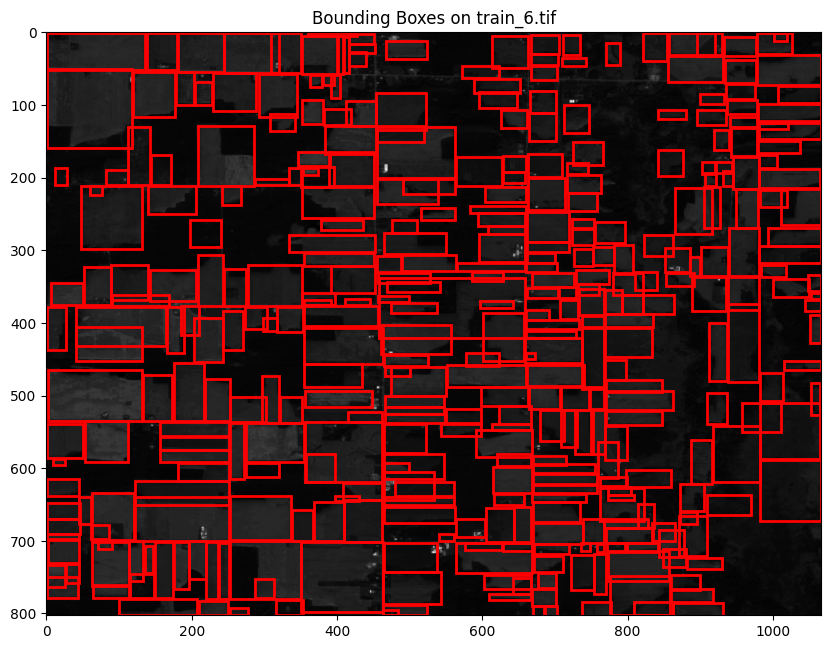

In [77]:
# Example usage
train_image_s3_uri = 's3://solafune/train_images/images/train_6.tif'
image_filename = train_image_s3_uri.split('/')[-1]
bboxes = bounding_boxes.get(image_filename, [])
visualize_bounding_boxes_with_rasterio(train_image_s3_uri, bboxes)